In [1]:
import os
import joblib
import pickle

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_tests
import pingouin as pg
from statsmodels.regression.mixed_linear_model import MixedLM
import statsmodels.formula.api as smf

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u



plt.rcParams['pdf.fonttype']=42
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [97]:
day = 5

In [98]:
# load session
sparse_sessions = stx.ymaze_sess_deets.SparseKO_sessions
mouse = 'SparseKO_05'
d = sparse_sessions[mouse][day]
date, scene, session, scan = d['date'], d['scene'], d['session'], d['scan']


pkldir = os.path.join('C://Users/esay/data/Stx3/YMazeSessPkls/', mouse,  date, f'{scene}_{session}.pkl')
sess = stx.session.YMazeSession.from_file(pkldir, verbose=False)


In [9]:
# blocked days
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
channel_0_mask = sess.trial_info['block_number']%2==0
left_mask = sess.trial_info['LR']==-1


trial_masks['channel_0_left'] = channel_0_mask*left_mask
trial_masks['channel_0_right'] = channel_0_mask*~left_mask
trial_masks['channel_1_left'] = ~channel_0_mask*left_mask
trial_masks['channel_1_right'] = ~channel_0_mask*~left_mask


In [99]:
# non-blocked days
trial_masks = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}
left_mask = sess.trial_info['LR']==-1

trial_masks['channel_0_left'] = left_mask
trial_masks['channel_0_right'] = ~left_mask
trial_masks['channel_1_left'] = left_mask
trial_masks['channel_1_right'] = ~left_mask

In [23]:
# # pc mask

# chan0_mask_pf_left = sess.place_cell_info['channel_0_F_dff']['left']['masks']
# chan0_mask_pf_right = sess.place_cell_info['channel_0_F_dff']['right']['masks']
# chan1_mask_pf_left = sess.place_cell_info['channel_1_F_dff']['left']['masks']
# chan1_mask_pf_right = sess.place_cell_info['channel_1_F_dff']['right']['masks']

# chan1_mask = chan1_mask_pf_left | chan1_mask_pf_right
# chan0_mask = chan0_mask_pf_left | chan0_mask_pf_right

In [24]:
# F1 = sess.timeseries['channel_1_spks']
# F_chan1_mask = F1[chan1_mask] 

# F0 = sess.timeseries['channel_0_spks']
# F_chan0_mask = F0[chan0_mask]

In [29]:
def run_shuffle(F, trial_starts, teleports, t, rng):
    
    F_shuff = np.zeros_like(F)
    
    for trial, (start, stop) in enumerate(zip(trial_starts, teleports)):
        _F = 1*F[:,start:stop]    
        _F = np.roll(_F,rng.integers(0,stop-start),axis=-1)
        F_shuff[:,start:stop] = 1*_F
        
    tmat = tpu.spatial_analyses.trial_matrix(F_shuff.T,t, trial_starts,
                                            teleports, min_pos=13, max_pos=43, bin_size=1, mat_only=True)
    
    return np.nanmean(tmat,axis=0)




In [68]:
len(sess.timeseries['channel_1_spks'])

126

In [26]:
# # shuffle pc only 

# rng = np.random.default_rng()

# shuff_thresh = {'channel_0_left': None,
#                'channel_0_right': None,
#                'channel_1_left': None,
#                'channel_1_right': None}


# F = F_chan0_mask
# starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
# shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
# shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

# F = F_chan0_mask
# starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
# shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
# shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


# F = F_chan1_mask
# starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
# shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
# shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

# F = F_chan1_mask
# starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
# shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
# shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)




In [36]:
shuff_trial_mat.shape

(1000, 30, 270)

In [100]:
rng = np.random.default_rng()

shuff_thresh = {'channel_0_left': None,
               'channel_0_right': None,
               'channel_1_left': None,
               'channel_1_right': None}

F = sess.timeseries['channel_0_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_left']], sess.teleport_inds[trial_masks['channel_0_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = sess.timeseries['channel_0_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_0_right']], sess.teleport_inds[trial_masks['channel_0_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_0_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)


F = sess.timeseries['channel_1_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_left']], sess.teleport_inds[trial_masks['channel_1_left']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_left'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)

F = sess.timeseries['channel_1_spks']
starts, stops = sess.trial_start_inds[trial_masks['channel_1_right']], sess.teleport_inds[trial_masks['channel_1_right']]
shuff_trial_mat = np.array(joblib.Parallel(n_jobs=-1)(joblib.delayed(run_shuffle)(F, starts, stops, sess.vr_data['t'], rng) for i in range(1000)))
shuff_thresh['channel_1_right'] = np.nanpercentile(shuff_trial_mat[:, :, :], 99, axis=0)




In [38]:
# pc only 

trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :][...,chan0_mask_pf_left],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :][...,chan0_mask_pf_right],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :][...,chan1_mask_pf_left],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :][...,chan1_mask_pf_right],axis=0),
              }

In [43]:
sess.trial_matrices['channel_0_spks'].shape

(140, 30, 270)

In [101]:
trial_means = {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :],axis=0),
              }

In [6]:
import pickle

with open('C://Users/esay/data/Stx3/YMazeSessPkls/place_field_shuff_SparseKO_05.pkl','wb') as file:
    pickle.dump(shuff_thresh,file)

In [24]:
# import pickle 
# with open('place_field_shuff_SparseKO_02.pkl','rb') as file:
#     shuff_thresh = pickle.load(file)

In [102]:
shuff_thresh['channel_0_right'].shape

(30, 156)

In [103]:
trial_means['channel_0_right'].shape

(30, 156)

In [104]:
field_info = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}

for k, thresh in shuff_thresh.items():
    
    sig_bins = trial_means[k]>thresh

    # eliminate fields that start at first bin of track or end at last bin of track
    

    ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
    
    for _ledge in ledges:

        rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
        _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
        # print(_redge.size)
        if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0):
            field_info[k].append([_ledge[1], _ledge[0], _redge[0][0]])


for k,v in field_info.items():
    field_info[k]=np.array(v)

In [95]:
field_info['channel_0_left'].shape

(214, 3)

(array([0.68085106, 0.23404255, 0.08510638, 0.        ]),
 array([1., 2., 3., 4., 5.]),
 <BarContainer object of 4 artists>)

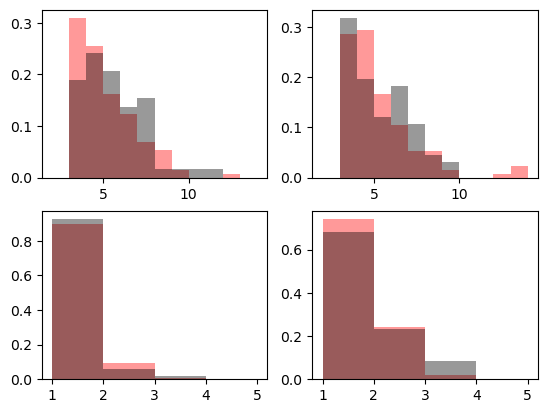

In [105]:
fig, ax = plt.subplots(2,2)

width_bins = np.arange(2,15)
field_bins = np.arange(1,6)
##
fi = field_info['channel_0_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)

##
fi = field_info['channel_1_left']
ax[0,0].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,0].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)

##
fi = field_info['channel_0_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='red', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='red', alpha=.4, density=True)


##
fi = field_info['channel_1_right']
ax[0,1].hist(fi[:,2], bins=width_bins, color='black', alpha=.4, density=True)

cell_list = np.unique(fi[:,0])
nfields = np.array([np.count_nonzero(fi[:,0]==cell) for cell in cell_list])
ax[1,1].hist(nfields, bins=field_bins, color='black', alpha=.4, density=True)


    

In [106]:
# shuff_results = {}

# shuff_results[mouse] = {}
shuff_results[mouse][day] = {}
shuff_results[mouse][day] = shuff_thresh

shuff_results[mouse].keys()

dict_keys([0, 1, 2, 3, 5])

In [109]:
sparse_mice = stx.ymaze_sess_deets.sparse_mice

In [ ]:
trial_means = {}

for mouse in sparse_mice[0:1]:
    trial_means[mouse] = {}
    for day in range(6):
        
        
        temp_trial_means= {'channel_0_left': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_left'], : , :],axis=0),
               'channel_0_right': np.nanmean(sess.trial_matrices['channel_0_spks'][trial_masks['channel_0_right'], : , :],axis=0),
               'channel_1_left': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_left'], : , :],axis=0),
               'channel_1_right': np.nanmean(sess.trial_matrices['channel_1_spks'][trial_masks['channel_1_right'], : , :],axis=0),
              }

        trial_means[mouse][day] = temp_trial_means

In [110]:
# field_info = {'channel_0_left': [],
#                'channel_0_right': [],
#                'channel_1_left': [],
#                'channel_1_right': []}
field_info = {}
for mouse in sparse_mice:
    field_info[mouse] = {}
    for day in range(6):
        field_info[mouse][day] = {'channel_0_left': [],
               'channel_0_right': [],
               'channel_1_left': [],
               'channel_1_right': []}
        for k, thresh in shuff_results[mouse][day].items():
            # print(k, thresh.shape)
            sig_bins = trial_means[mouse][day][k]>thresh
        
            # eliminate fields that start at first bin of track or end at last bin of track
            
        
            ledges = np.argwhere(sig_bins[1:,:]>sig_bins[:-1,:])
            
            for _ledge in ledges:
        
                rem_trial = sig_bins[_ledge[0]:,_ledge[1]]
                _redge = np.argwhere(rem_trial[1:]<rem_trial[:-1])
                # print(_redge.size)
                if (_redge.shape[0]>0) and (_redge[0][0]>2) and (_redge[0][0]<15) and (_ledge[0]>0) and ((_redge[0][0]+_ledge[0])<29):
                # if (_redge.shape[0]>0):
                # if (_redge.shape[0]>0):
                    field_info[mouse][day][k].append([_ledge[1], _ledge[0], _redge[0][0]])


        for k,v in field_info[mouse][day].items():
            field_info[mouse][day][k]=np.array(v)

KeyError: 'SparseKO_05'

In [ ]:
df = {'mouse': [],
      'cond':[],
      'ttype':[],
      'day':[],
      'field_width':[],
      'n_fields':[]}

for mouse in sparse_mice:
    for day in range(6):
        for ttype in ('channel_0_left','channel_0_right', 'channel_1_left', 'channel_1_right'):
            df['mouse'].append(mouse)

            if ttype.find('channel_0'):
                df['cond'].append('cre') # seperate channel0 from left and right
            elif ttype.find('channel_0'):
                df['cond'].append('ctrl')

            if ttype.find('left'):
                df['ttype'].append('nov')
            elif ttype.find('right'):
                df['ttype'].append('fam')

            df['day'].append(day)

            f_info = np.array(field_info[mouse][day][ttype])
            df['field_width'].append(f_info[:,2].mean())
            
            cell_list = np.unique(f_info[:,0])
            df['n_fields'].append(np.array([np.count_nonzero(f_info[:,0]==cell) for cell in cell_list]).mean())

            
df = pd.Dataframe(df)
            